In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
path_to_pictures = '/content/drive/MyDrive/pic/'
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/CVNLP/dataset_faces.csv'

# What is Data Augmentation?

Data Augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified data from the existing one.

It is a good technique if you want to prevent overfitting, or the initial dataset is too small to train on, or even if you want to squeeze better performance from your model.

Data Augmentation in computer vision is used to generate new images through different techniques. 

## Data Augmentation techniques
* Geometric transformations: Randomly flip, crop, rotate or translate images.
* Color space transformations: change RGB color channels, intensify any color.
* Kernel filters: sharpen or blur an image.
* Random Erasing: delete a part of the initial image.
* Mixing images: basically, mix images with one another.

All these operations are applicable for classification problems where the location of objects in the image does not matter. In object detection task, where the location of the objects is what we want to detect, these techniques might not be appropriate. 

## Data Augmentation Frameworks:
* TensorFlow
* Keras
* PyTorch


Sources:
* https://neptune.ai/blog/data-augmentation-in-python
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=dataloader
* https://towardsdatascience.com/a-comprehensive-guide-to-image-augmentation-using-pytorch-fb162f2444be
* https://www.youtube.com/watch?v=vo_fUOk-IKk&list=PLWKjhJtqVAbm3T2Eq1_KgloC7ogdXxdRa

In [56]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Data and images

In [57]:
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [58]:
df = pd.read_csv(path_to_dataset)

In [59]:
df.head()

,filename,age,gender,ethnicity
0,100_1_0_20170110183726390.jpg,100,1,0
1,100_1_2_20170105174847679.jpg,100,1,2
2,100_1_2_20170110182836729.jpg,100,1,2
3,101_1_2_20170105174739309.jpg,101,1,2
4,10_0_0_20161220222308131.jpg,10,0,0


# Get pictures as numpy arrays

In [60]:
images = []

for idx, image in enumerate(df['filename'][0:10]):
  print(image)
  path = path_to_pictures + image
  img = Image.open(path)
  #img = np.array(img)
  images.append(img)

100_1_0_20170110183726390.jpg
100_1_2_20170105174847679.jpg
100_1_2_20170110182836729.jpg
101_1_2_20170105174739309.jpg
10_0_0_20161220222308131.jpg
10_0_0_20170103200329407.jpg
10_0_0_20170103200522151.jpg
10_0_0_20170103233459275.jpg
10_0_0_20170104013211746.jpg
10_0_0_20170110215927291.jpg


In [61]:
print(images[0])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x470 at 0x7F3BF99E8710>


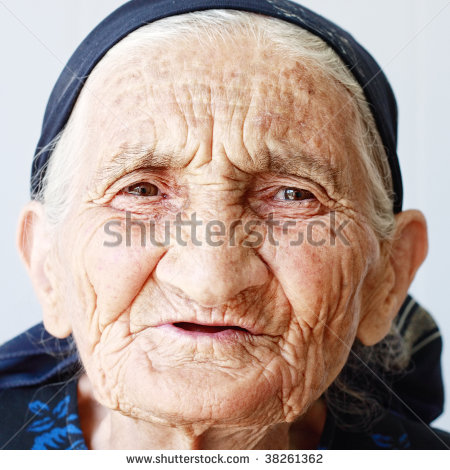

In [62]:
#images[0].show()
images[0]

# Data Augmentation in PyTorch

PyTorch contains the transforms library for data augmentation.

Transform library contains different image transformations that can be chained together using the compose method.

An Image transformation is the process to change the original values of image pixels to a set of new values. 

## Resize

One issue we can face is that the samples are not of the same size. Most neural networks expect the images of fixed size.


In [65]:
# Investigate size of the first 5 pictures:
pixels_in_x_axis = []
pixels_in_y_axis = []

for idx, img in enumerate(images):
  img_array = np.array(img)
  pixels_in_x_axis.append(img_array.shape[0])
  pixels_in_y_axis.append(img_array.shape[1])
  if idx < 5: 
    print(f"Image {idx} has shape {img_array.shape}")

Image 0 has shape (470, 450, 3)
Image 1 has shape (441, 332, 3)
Image 2 has shape (680, 488, 3)
Image 3 has shape (487, 602, 3)
Image 4 has shape (451, 452, 3)


In [66]:
pixels_in_x_axis = pd.Series(pixels_in_x_axis)
pixels_in_y_axis = pd.Series(pixels_in_y_axis)

print(f"Mean size for pictures is ({pixels_in_x_axis.mean()} , {pixels_in_y_axis.mean()})")
print(f"Smaller size for x is {pixels_in_x_axis.min()} pixel and for y {pixels_in_y_axis.min()} pixels.")

Mean size for pictures is (559.4 , 561.2)
Smaller size for x is 251 pixel and for y 252 pixels.


In [98]:
resized_images = []
size = (64, 64)
for img in images:
  resized_img = T.Resize(size=size) (img)
  resized_images.append(resized_img)

In [99]:
for idx, img in enumerate(resized_images[0:5]):
  img_array = np.array(img)
  print(f"Image {idx} has shape {img_array.shape}")

Image 0 has shape (64, 64, 3)
Image 1 has shape (64, 64, 3)
Image 2 has shape (64, 64, 3)
Image 3 has shape (64, 64, 3)
Image 4 has shape (64, 64, 3)


In [100]:
print(resized_images[0])

<PIL.Image.Image image mode=RGB size=64x64 at 0x7F3BF985CA90>


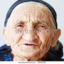

In [101]:
resized_images[0]

# Normalize Pictures with PyTorch

The normalization can constitute an effective way to speed up the computation in the model based on neural network architecture and learn faster by reducing the skewness. 

There are 2 steps to normalize the images: 


1.   Substract the channel mean from each input channel
2.   Dived it by the channel standard deviation

When we transformed an image into a PyTorch tensor, the pixel values are scaled between 0 and 1. In PyTorch, this transformation is done usint torchvision.transforms.ToTensor(). This converts the PIL image with a pixel range of 0 to 255 to a PyTorch FloatTensor of shape (C, H, W) with a range from 0 to 1. 

**Normalizing the images means transforming the images into such values that the mean and stadard deviation of the image become 0 and 1 respectively.**

To actually normalize the image, then we use torchvision.transforms.Normalize(). 

Normalize() takes 2 parameters: 
* mean: Sequeance of means for each channel. 
* std. Sequence of standard deviations for each channel. 
And it returns a normalized tensor image. 

To normalize the image we first calculate the mean and standard deviation of 10 random pictures. 

In [102]:
# Transform images to tensor images: 
tensor_images = []
for idx, img in enumerate(resized_images):
  tensor_img = (T.ToTensor())(img) # Transform image to pixel values btw 0 and 1
  tensor_images.append(tensor_img)

In [103]:
tensor_images[0]

tensor([[[0.8980, 0.9059, 0.9020,  ..., 0.8745, 0.8745, 0.8706],
         [0.9020, 0.8980, 0.9020,  ..., 0.8745, 0.8706, 0.8706],
         [0.9020, 0.9020, 0.8980,  ..., 0.8745, 0.8745, 0.8745],
         ...,
         [0.7412, 0.7333, 0.7294,  ..., 0.7137, 0.7137, 0.7255],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9098, 0.9176, 0.9216,  ..., 0.8941, 0.8941, 0.8902],
         [0.9176, 0.9137, 0.9216,  ..., 0.8941, 0.8902, 0.8902],
         [0.9216, 0.9176, 0.9137,  ..., 0.8941, 0.8941, 0.8941],
         ...,
         [0.7569, 0.7490, 0.7451,  ..., 0.7137, 0.7176, 0.7255],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9373, 0.9451, 0.9451,  ..., 0.9098, 0.9098, 0.9059],
         [0.9451, 0.9412, 0.9451,  ..., 0.9098, 0.9098, 0.9137],
         [0.9451, 0.9412, 0.9412,  ..., 0.9098, 0.9137, 0.

Text(0.5, 1.0, 'distribution of pixels for first picture')

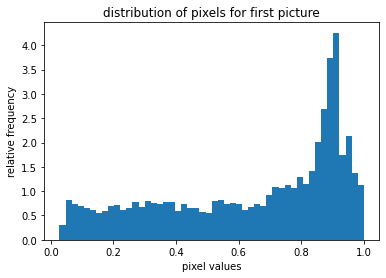

In [104]:
# Plot pixel values of first image: 
array_img = np.array(tensor_images[0])

plt.hist(array_img.ravel(), bins=50, density=True)
plt.xlabel('pixel values')
plt.ylabel('relative frequency')
plt.title('distribution of pixels for first picture')

In [105]:
# Calculate mean and standard deviation for 10 random pictures: 
import random
mean_pixels = torch.zeros([3, 10])
std_pixels = torch.zeros([3, 10])

for idx, img in enumerate(random.sample(tensor_images, k=10)):
  mean = img.mean([1,2])
  std = img.std([1,2])
  mean_pixels[:, idx] = mean 
  std_pixels[:, idx] = std

mean = mean_pixels.mean(1)
std = std_pixels.mean(1)

print(f"Mean of 10 random images: {mean}")
print(f"Std of 10 random images: {std}")

Mean of 10 random images: tensor([0.5670, 0.5007, 0.4801])
Std of 10 random images: tensor([0.2496, 0.2239, 0.2278])


In [106]:
normalized_images_tensor = []
normalized_images = []
# Instanciate Normalize() function with calculated mean and std
normalizer = T.Normalize(mean=list(mean), std=list(std))
for idx, img in enumerate(tensor_images): 
  normalized_img = normalizer(img)
  normalized_images_tensor.append(normalized_img)
  normalized_img = T.ToPILImage()(normalized_img)
  normalized_images.append(normalized_img)

In [107]:
print(normalized_images[0])

<PIL.Image.Image image mode=RGB size=64x64 at 0x7F3BF964B790>


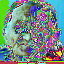

In [108]:
normalized_images[0]

In [109]:
print(normalized_images_tensor[0])

tensor([[[1.3260, 1.3574, 1.3417,  ..., 1.2318, 1.2318, 1.2161],
         [1.3417, 1.3260, 1.3417,  ..., 1.2318, 1.2161, 1.2161],
         [1.3417, 1.3417, 1.3260,  ..., 1.2318, 1.2318, 1.2318],
         ...,
         [0.6976, 0.6662, 0.6505,  ..., 0.5876, 0.5876, 0.6348],
         [1.7345, 1.7345, 1.7345,  ..., 1.7345, 1.7345, 1.7345],
         [1.7345, 1.7345, 1.7345,  ..., 1.7345, 1.7345, 1.7345]],

        [[1.8267, 1.8618, 1.8793,  ..., 1.7567, 1.7567, 1.7392],
         [1.8618, 1.8443, 1.8793,  ..., 1.7567, 1.7392, 1.7392],
         [1.8793, 1.8618, 1.8443,  ..., 1.7567, 1.7567, 1.7567],
         ...,
         [1.1438, 1.1088, 1.0913,  ..., 0.9512, 0.9687, 1.0037],
         [2.2295, 2.2295, 2.2295,  ..., 2.2295, 2.2295, 2.2295],
         [2.2295, 2.2295, 2.2295,  ..., 2.2295, 2.2295, 2.2295]],

        [[2.0070, 2.0414, 2.0414,  ..., 1.8865, 1.8865, 1.8693],
         [2.0414, 2.0242, 2.0414,  ..., 1.8865, 1.8865, 1.9037],
         [2.0414, 2.0242, 2.0242,  ..., 1.8865, 1.9037, 1.

# Split data

In [110]:
X = normalized_images_tensor
y = df['gender'][0:10]

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [112]:
# Convert features (X) into torch format: 
# Not necessary: X_train is already tensor
X_train[0]

tensor([[[ 0.8390,  0.8547,  0.8547,  ...,  1.7188,  1.7031,  1.7031],
         [ 0.7919,  0.8233,  0.8547,  ...,  1.7031,  1.6874,  1.6874],
         [ 0.7605,  0.7762,  0.8233,  ...,  1.7031,  1.6874,  1.6874],
         ...,
         [-1.9889, -2.0988, -2.1460,  ..., -1.5333, -1.5176, -1.5176],
         [-2.0988, -2.1303, -2.1617,  ..., -1.5176, -1.5333, -1.5490],
         [-2.0988, -2.1460, -2.1617,  ..., -1.5333, -1.5333, -1.5018]],

        [[ 0.8636,  0.8811,  0.8811,  ...,  0.7936,  0.8286,  0.8811],
         [ 0.8111,  0.8461,  0.8811,  ...,  0.7586,  0.8111,  0.8636],
         [ 0.7761,  0.7936,  0.8461,  ...,  0.7060,  0.8111,  0.8461],
         ...,
         [-2.0257, -2.1308, -2.1308,  ..., -1.4128, -1.3953, -1.3953],
         [-2.0957, -2.1308, -2.1483,  ..., -1.3953, -1.4128, -1.4303],
         [-2.0782, -2.1308, -2.1308,  ..., -1.4128, -1.4128, -1.3778]],

        [[ 1.0257,  1.0430,  1.0430,  ...,  0.7675,  0.8192,  0.8536],
         [ 0.9741,  1.0085,  1.0430,  ...,  0

In [113]:
# Convert target into torch format:
y_train = np.array(y_train)
y_train = torch.tensor(y_train)
y_train[0]

tensor(0)

# Using a TensorDataset:

In [134]:
# Get y: 
tensor_y = np.array(df['gender'][0:10])
tensor_y = torch.from_numpy(tensor_y)

In [115]:
X = normalized_images_tensor
X[0].shape

torch.Size([3, 64, 64])

In [118]:
# Get X: it is a list of tensors: 
tensor_X = torch.zeros(len(X), 3, 64, 64)
for idx, x in enumerate(X):
  tensor_X[idx] = x 

In [136]:
from torch.utils.data import TensorDataset
tensor_ds = TensorDataset(tensor_X, tensor_y)

In [129]:
img, label = tensor_ds[4]
print(img.shape, label)

torch.Size([3, 64, 64]) tensor(0)


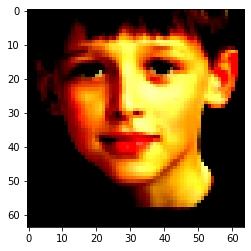

In [130]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [138]:
print(tensor_ds.label)

AttributeError: ignored

In [121]:
# split dataset with PyTorch
from torch.utils.data import random_split
train_size = int(len(tensor_ds) * 0.8)
test_size = int(len(tensor_ds) * 0.2)


train_ds, test_ds = random_split(tensor_ds, [train_size, test_size])
print(len(train_ds))
print(len(test_ds))

8
2


In [122]:
# Load the data
from torch.utils.data import DataLoader
batch_size=5
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size)

The dataloader allows to split the data into batches of a predifined size while training. The pictures for the dataloader will be randomly selected (shuffle=True)

In [123]:
# Augmenting using np arrays: 
final_train_data = []
final_target_train = []
for i in tqdm(range(train_x.shape[0])):
    final_train_data.append(train_x[i])
    final_train_data.append(rotate(train_x[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(train_x[i]))
    final_train_data.append(np.flipud(train_x[i]))
    final_train_data.append(random_noise(train_x[i],var=0.2**2))
    for j in range(5):
        final_target_train.append(train_y[i])

# Source: 
https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

SyntaxError: ignored